## Climate time series analysis
* Charge and preprocess data
* Time series clustering 
* Causal analysis

In [19]:
import pandas as pd
import numpy as np
import os
import datetime
from tensorflow.keras import layers, Model
from tslearn.clustering import TimeSeriesKMeans
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
col_names = pd.read_csv('../dades/col_names.txt', header=None)
df = pd.DataFrame()

df.loc[:,'timestamp'] = pd.read_csv('../dades/data_per_pix/-0.5,-48.5.csv', header=None).loc[:,0].apply(datetime.datetime.fromtimestamp)

In [3]:
variables_names = ['Lag_RN_ERA_Ix5day_2', 'Lag_SM_GLEAM_ResPlusTrend_Sx5day_2','maxTXx_cum_T_ERA_2', 'monthly_Rx1day_P_CPCU']
variables_ind = [1486, 2109, 4225, 5007]

In [20]:
df = np.empty((len(os.listdir('../test_data/new_data/')),385,4))
pixels = []
i = 0



for file in os.listdir('../test_data/new_data/'):
    df[i,:,:] = pd.read_csv(os.path.join('../test_data/new_data/', file), header=None)
    i += 1
    pixels.append(file)
    


In [21]:
inp = layers.Input(shape=(df.shape[1], df.shape[2]))
    

encoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(inp)
encoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(encoder)
latent = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(encoder)
decoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(latent)
decoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(decoder)
out = layers.TimeDistributed(layers.Dense(4))(decoder)

autoencoder = Model(inputs=inp, outputs=out)
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 385, 4)]          0         
                                                                 
 time_distributed_6 (TimeDis  (None, 385, 50)          250       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 385, 10)          510       
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 385, 1)           11        
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 385, 10)          20        
 tributed)                                                 

In [22]:
ind = np.random.permutation(df.shape[0])
training_idx, test_idx = ind[:8000], ind[8000:]
x_train, x_test = df[training_idx,:,:], df[test_idx,:,:]

In [24]:
history = autoencoder.fit(x_train, x_train, epochs = 500, validation_data= (x_test, x_test))

Epoch 1/500
250/250 [==============================] - 3s 13ms/step - loss: 23391.0781 - val_loss: 23319.6934
Epoch 2/500
250/250 [==============================] - 3s 10ms/step - loss: 23242.9277 - val_loss: 23174.6602
Epoch 3/500
250/250 [==============================] - 2s 10ms/step - loss: 23099.4766 - val_loss: 23027.5488
Epoch 4/500
250/250 [==============================] - 2s 10ms/step - loss: 22951.8691 - val_loss: 22882.7520
Epoch 5/500
250/250 [==============================] - 2s 10ms/step - loss: 22807.7871 - val_loss: 22738.4512
Epoch 6/500
250/250 [==============================] - 2s 10ms/step - loss: 22664.5176 - val_loss: 22595.5410
Epoch 7/500
250/250 [==============================] - 3s 11ms/step - loss: 22521.9297 - val_loss: 22453.9922
Epoch 8/500
250/250 [==============================] - 3s 11ms/step - loss: 22380.1328 - val_loss: 22312.3477
Epoch 9/500
250/250 [==============================] - 2s 9ms/step - loss: 22239.3398 - val_loss: 22172.1328
Epoch 10/50

In [25]:
encoder = Model(inputs=inp, outputs=latent)
encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 385, 4)]          0         
                                                                 
 time_distributed_6 (TimeDis  (None, 385, 50)          250       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 385, 10)          510       
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 385, 1)           11        
 tributed)                                                       
                                                                 
Total params: 771
Trainable params: 771
Non-trainable params: 0
_____________________________________________________________

In [26]:
data = encoder.predict(df)

409/409 [==============================] - 1s 2ms/step


In [27]:
data = data.reshape((len(os.listdir('../test_data/new_data/')), 385))

In [28]:
data = pd.DataFrame(data, index = pixels)

In [29]:
model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=100)
model.fit(data)

KeyboardInterrupt: 

In [13]:
results = pd.DataFrame()

In [14]:
results['group'] = model.predict(data)


c:\Users\Usuario\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 130 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [15]:
coord_x = []
coord_y = []

for i in range(len(pixels)):
    pixels[i] = pixels[i].replace('.csv', '')
    coord_x.append(float(pixels[i].split(',')[1]))
    coord_y.append(float(pixels[i].split(',')[0]))

In [16]:
results['coord_x'] = coord_x
results['coord_y'] = coord_y


In [22]:
results

,group,coord_x,coord_y
0,0,-48.5,-0.5
1,0,-49.5,-0.5
2,0,-50.5,-0.5
3,0,10.5,-0.5
4,0,11.5,-0.5
...,...,...,...
139,2,96.5,79.5
140,2,97.5,79.5
141,2,-66.5,80.5
142,2,-68.5,81.5


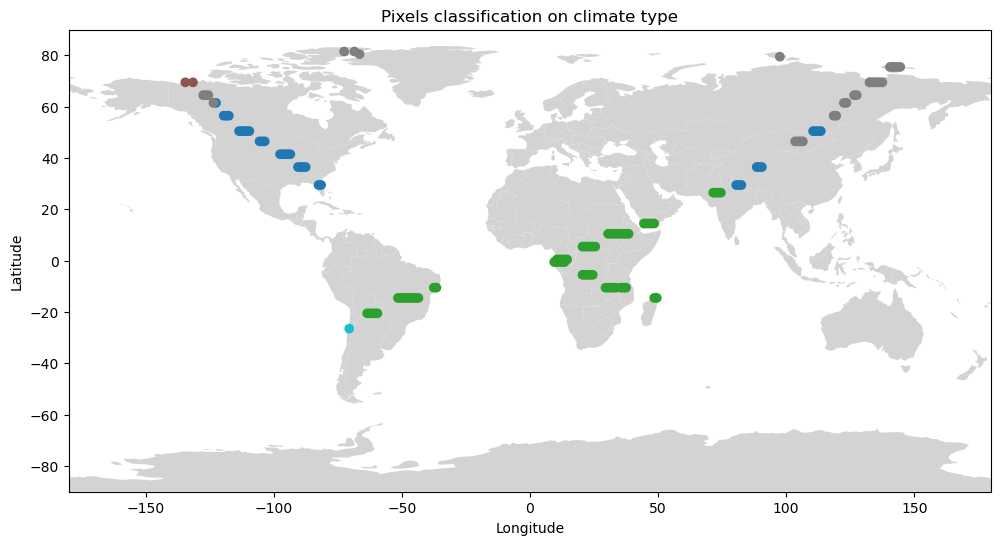

In [17]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)


# Plotting our pixels classification by climate type
x = tuple(results['coord_x'])
y = tuple(results['coord_y'])
z = tuple(results['group'])


plt.scatter(x, y, c=z, cmap='tab10')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title('Pixels classification on climate type')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()